In [69]:
#Loading the datasets
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd

In [70]:
#Reading the CSV file
sample_submission = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
sample_submission.head(2)

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water


In [71]:
#Training the dataset
train_file = pd.read_csv('../input/planets-dataset/planet/planet/train_classes.csv', dtype = str)
train_file.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [72]:
#sample image
from skimage import io
%matplotlib inline

In [73]:
sample_image = io.imread('../input/planets-dataset/planet/planet/train-jpg/train_20.jpg')
sample_image.shape

(256, 256, 3)

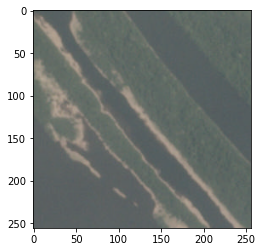

In [74]:
plt.imshow(sample_image)

In [75]:
train_file[train_file['image_name'] == 'train_20']

,image_name,tags
20,train_20,agriculture clear primary water


In [76]:
unique_labels = set()
def append_labels(tags):
    for tag in tags.split():
        unique_labels.add(tag)
        
train_df = train_file.copy()
train_df['tags'].apply(append_labels)
unique_labels = list(unique_labels)
print(unique_labels)

['artisinal_mine', 'selective_logging', 'agriculture', 'road', 'blooming', 'slash_burn', 'habitation', 'cultivation', 'partly_cloudy', 'conventional_mine', 'haze', 'clear', 'cloudy', 'bare_ground', 'blow_down', 'water', 'primary']


In [77]:
assert len(train_df['image_name'].unique()) == train_df.shape[0]

In [78]:
for tag in unique_labels:
    train_df[tag] = train_df['tags'].apply(lambda x: 1 if tag in x.split() else 0)
train_df.head()

,image_name,tags,artisinal_mine,selective_logging,agriculture,road,blooming,slash_burn,habitation,cultivation,partly_cloudy,conventional_mine,haze,clear,cloudy,bare_ground,blow_down,water,primary
0,train_0,haze primary,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,train_1,agriculture clear primary water,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1
2,train_2,clear primary,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,train_3,clear primary,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,train_4,agriculture clear habitation primary road,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1


In [79]:
train_df['image_name'] = train_df['image_name'].apply(lambda x: '{}.jpg'.format(x))
train_df.head()

,image_name,tags,artisinal_mine,selective_logging,agriculture,road,blooming,slash_burn,habitation,cultivation,partly_cloudy,conventional_mine,haze,clear,cloudy,bare_ground,blow_down,water,primary
0,train_0.jpg,haze primary,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,train_1.jpg,agriculture clear primary water,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1
2,train_2.jpg,clear primary,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,train_3.jpg,clear primary,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,train_4.jpg,agriculture clear habitation primary road,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1


In [80]:
labels = list(train_df.columns[2:])
labels

['artisinal_mine',
 'selective_logging',
 'agriculture',
 'road',
 'blooming',
 'slash_burn',
 'habitation',
 'cultivation',
 'partly_cloudy',
 'conventional_mine',
 'haze',
 'clear',
 'cloudy',
 'bare_ground',
 'blow_down',
 'water',
 'primary']

In [81]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [82]:
image_gen = ImageDataGenerator(rescale = 1/255, validation_split = 0.20)

In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [84]:
def fbeta(ytrue, ypred, beta = 2, epsilon = 1e-4):
    beta_sqd = beta**2
    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(0.5)), tf.float32)
    
    true_pos = tf.reduce_sum(ytrue * ypred, axis = 1)
    false_pos = tf.reduce_sum(ypred, axis = 1) - true_pos
    false_neg = tf.reduce_sum(ytrue, axis = 1) - true_pos
    
    precision = true_pos / (true_pos + false_pos + epsilon)
    recall = true_pos / (true_pos + false_neg + epsilon)
    
    fb = (1 + beta_sqd) * precision * recall / (beta_sqd * precision + recall + epsilon)
    return fb

In [85]:
def multi_label_acc(ytrue, ypred, epsilon = 1e-4):
    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(0.5)), tf.float32)
    
    true_pos = tf.reduce_sum(ytrue * ypred, axis = 1)
    false_pos = tf.reduce_sum(ypred, axis = 1) - true_pos
    false_neg = tf.reduce_sum(ytrue, axis = 1) - true_pos
    
    ytrue = tf.cast(ytrue, tf.bool)
    ypred = tf.cast(ypred, tf.bool)
    
    true_neg = tf.reduce_sum(tf.cast(tf.logical_not(ytrue), tf.float32) * tf.cast(tf.logical_not(ypred), tf.float32), \
                             axis = 1)
    
    mla = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg + epsilon)
    return mla

In [86]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 128, kernel_size = 3, input_shape = (128, 128, 3)))
    model.add(Flatten())
    model.add(Dense(17, activation = 'sigmoid'))
    opt = Adam(lr=1e-2)
    model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = [multi_label_acc, fbeta])
    
    return model

In [87]:
save_best_checkpoint = ModelCheckpoint(filepath = 'best_model.hdf5', monitor = 'val_fbeta', \
                                      mode = 'max', save_best_only = True, save_weights_only = True)

In [88]:
train_gen = image_gen.flow_from_dataframe(dataframe = train_df, \
                                         directory = '../input/planets-dataset/planet/planet/train-jpg', x_col = 'image_name', y_col = labels, \
                                         target_size = (128,128), class_mode = 'raw', seed = 2, batch_size = 128, subset = 'training')

val_gen = image_gen.flow_from_dataframe(dataframe = train_df, \
                                         directory = '../input/planets-dataset/planet/planet/train-jpg', x_col = 'image_name', y_col = labels, \
                                         target_size = (128,128), class_mode = 'raw', seed = 2, batch_size = 128, subset = 'validation')

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [89]:
step_train_size = int(np.ceil(train_gen.samples / train_gen.batch_size))

step_val_size = int(np.ceil(val_gen.samples / val_gen.batch_size))

In [90]:
model1 = build_model()

model1.fit(x = train_gen, steps_per_epoch = step_train_size, validation_data = val_gen, validation_steps = step_val_size,
          epochs = 20, callbacks = [save_best_checkpoint])

Epoch 1/20
253/253 [==============================] - 135s 534ms/step - loss: 51.7560 - multi_label_acc: 0.8525 - fbeta: 0.5913 - val_loss: 5.4580 - val_multi_label_acc: 0.9067 - val_fbeta: 0.6712
Epoch 2/20
253/253 [==============================] - 114s 451ms/step - loss: 7.2452 - multi_label_acc: 0.8646 - fbeta: 0.6248 - val_loss: 3.7848 - val_multi_label_acc: 0.8284 - val_fbeta: 0.6529
Epoch 3/20
253/253 [==============================] - 112s 442ms/step - loss: 72.2246 - multi_label_acc: 0.8548 - fbeta: 0.5999 - val_loss: 70.5092 - val_multi_label_acc: 0.8698 - val_fbeta: 0.4742
Epoch 4/20
253/253 [==============================] - 112s 444ms/step - loss: 76.2752 - multi_label_acc: 0.8644 - fbeta: 0.6210 - val_loss: 21.3676 - val_multi_label_acc: 0.8610 - val_fbeta: 0.6856
Epoch 5/20
253/253 [==============================] - 113s 445ms/step - loss: 106.7383 - multi_label_acc: 0.8643 - fbeta: 0.6223 - val_loss: 44.3640 - val_multi_label_acc: 0.8781 - val_fbeta: 0.6993
Epoch 6/20
2

In [91]:
model2 = build_model()

model2.load_weights('best_model.hdf5')

In [92]:
sample_submission_df = sample_submission.copy()
sample_submission_df['image_name'] = sample_submission_df['image_name'].apply(lambda x: '{}.jpg'.format(x))
len(sample_submission_df)

61191

In [93]:
test1_df = sample_submission_df.iloc[:40669]['image_name'].reset_index()
test1_df.drop('index', axis = 1)
test1_df.head(2)

,index,image_name
0,0,test_0.jpg
1,1,test_1.jpg


In [94]:
test1_gen = image_gen.flow_from_dataframe(dataframe = test1_df, \
                                         directory = '../input/planets-dataset/planet/planet/test-jpg', x_col = 'image_name', y_col = None, \
                                         target_size = (128,128), class_mode = None, shuffle = False, batch_size = 128)


Found 40669 validated image filenames.


In [95]:
step_test1_size = int(np.ceil(test1_gen.samples / test1_gen.batch_size))

In [96]:
test1_gen.reset()
pred1 = model2.predict(test1_gen, steps = step_test1_size, verbose = 1)

318/318 [==============================] - 147s 461ms/step


In [97]:
test1_file_names = test1_gen.filenames

pred1_tags = pd.DataFrame(pred1)
pred1_tags = pred1_tags.apply(lambda x: ' '.join(np.array(unique_labels)[x > 0.5]), axis = 1)

In [98]:
result1 = pd.DataFrame({'image_name': test1_file_names, 'tags': pred1_tags})
result1.head(2)

,image_name,tags
0,test_0.jpg,partly_cloudy clear primary
1,test_1.jpg,slash_burn clear blow_down primary


In [99]:
test2_df = sample_submission_df.iloc[40669:]['image_name'].reset_index()
test2_df.drop('index', axis = 1)
test2_df.head(2)

,index,image_name
0,40669,file_0.jpg
1,40670,file_1.jpg


In [100]:
test2_gen = image_gen.flow_from_dataframe(dataframe = test2_df, \
                                         directory = '../input/planets-dataset/test-jpg-additional/test-jpg-additional', x_col = 'image_name', y_col = None, \
                                         target_size = (128,128), class_mode = None, shuffle = False, batch_size = 128)


step_test2_size = int(np.ceil(test2_gen.samples / test2_gen.batch_size))

test2_gen.reset()
pred2 = model2.predict(test2_gen, steps = step_test2_size, verbose = 1)

test2_file_names = test2_gen.filenames

pred2_tags = pd.DataFrame(pred2)
pred2_tags = pred2_tags.apply(lambda x: ' '.join(np.array(unique_labels)[x > 0.5]), axis = 1)

result2 = pd.DataFrame({'image_name': test2_file_names, 'tags': pred2_tags})
result2.head(2)

Found 20522 validated image filenames.
161/161 [==============================] - 68s 424ms/step


,image_name,tags
0,file_0.jpg,partly_cloudy clear blow_down primary
1,file_1.jpg,artisinal_mine agriculture road habitation par...


In [101]:
final_result = pd.concat([result1, result2])

final_result = final_result.reset_index().drop('index', axis = 1)

final_result.head(2)

,image_name,tags
0,test_0.jpg,partly_cloudy clear primary
1,test_1.jpg,slash_burn clear blow_down primary
